In [2]:
import torch
import tqdm

from matplotlib import pyplot as plt
from statistics import mean
from torch import nn, optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets

# Generator
* Output image size is 64 x 64.
* 4 CNN layers.
* In each CNN layers, Transpose Convolution is used.

## ConvTranspose2d parameters
* in_channel
* out_channel
* kernel_size
* stride
* padding

## How Transpose Convolution works.
* https://lhopital.hatenablog.com/entry/2020/10/24/081133#%E3%82%B9%E3%83%88%E3%83%A9%E3%82%A4%E3%83%89-1
* https://github.com/vdumoulin/conv_arithmetic

In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Generator Operation Check
* input_z.shape: torch.Size([1, 20, 1, 1])
* layer1_output.shape: torch.Size([1, 512, 4, 4])
* layer2_output.shape: torch.Size([1, 256, 8, 8])
* layer3_output.shape: torch.Size([1, 128, 16, 16])
* layer4_output.shape: torch.Size([1, 64, 32, 32])
* last_output.shape: torch.Size([1, 1, 64, 64])

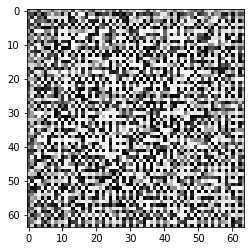

In [17]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()

plt.imshow(img_transformed, cmap='gray')
plt.show()

# Discriminator
* Applys CNN layer 5 times, then applys sigmoid activation function.
* input.shape: torch.Size([1, 1, 64, 64])
* output.shape: torch.Size([1, 1, 1, 1])

In [33]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.Sigmoid()(self.last(out))
        
        return out

# Descriminator Operation Check

In [34]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_image = G(input_z)

d_out = D(fake_image)

#print(nn.Sigmoid()(d_out))
print(d_out)

tensor([[[[0.5021]]]], grad_fn=<SigmoidBackward>)
